## This notebook walks through processing WQP data using the harmonize-wq package

##### import the required libraries. Check requirements.txt for dependencies that should be installed.

In [1]:
import os
import geopandas
import pandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
import dataretrieval.wqp as wqp

#### Download location data using dataretrieval

In [2]:
# Read geometry for Area of Interest from url to it in public repo
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
# Note: alternatively you can direct it to a local shapefile:
#aoi_url = r'<your filepath>\NewEngland.shp'
aoi_gdf = geopandas.read_file(aoi_url)  # Read it to GeoDataFrame
aoi_gdf = aoi_gdf.to_crs(epsg=4326)  # Re-project aoi

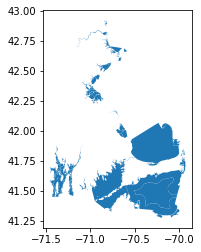

In [3]:
# Map aoi
aoi_gdf.plot() # Requires descartes

In [4]:
# Since there are so many small polygons query by full extent instead of one
#bBox = wrangle.get_bounding_box(aoi_gdf)  #get bBox string for specific polygon
bBox = ','.join(map(str, aoi_gdf.total_bounds))  #get bBox string for total extent of all

In [5]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(7192, 36)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,CountyCode,AquiferName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName      NAD83
LatitudeMeasure                                 42.6774
LongitudeMeasure                               -71.4211
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = harmonize.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [11]:
# Every function has a dostring to help understand input/output and what it does
harmonize.harmonize_locations?

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(7192, 41)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                    4269
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

In [16]:
# Clip to area of interest
stations_clipped = geopandas.clip(stations_gdf, aoi_gdf)

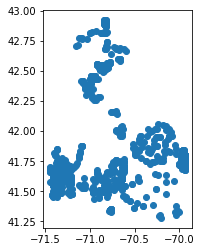

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

1213

In [19]:
# To save the results to a shapefile
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(, path, )'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\ArcGIS\Local_GIS\Python\envs\arc-py3-osgeo\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,62,63,64,65,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_LS_PB_7/16/2013_MFW_0.441,2013-07-16,12:40:00,EDT,11NPSWRD_WQX-CACO_LS_PB,STORET-920933446,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131008269TEC01,2013-10-08,06:08:00,EST,CRWA-269T,STORET-872380044,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,11113300,New Hampshire Department Of Environmental Serv...,11113300-DWWTF08192013-3,2013-08-19,NaN,NaN,11113300-BCHDTBDERLF,STORET-271839243,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-15-0391,2013-06-26,11:06:00,EDT,MASSDEP-W2412,STORET-762962184,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,MYRWA,Mystic River Watershed Association (Massachuse...,MYRWA-MAR036:201308210635:L:S,2013-08-21,05:35:00,EST,MYRWA-MAR036,STORET-495269544,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329480,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123251862,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
329481,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123251872,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
329482,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123251879,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
329483,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123251881,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


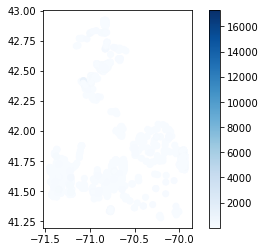

In [22]:
# Map counts of all results
results_cnt = df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
results_cnt.reset_index(inplace=True)

# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(results_cnt, stations_clipped, gdf_cols, merge_cols)
cnt_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')

# Map it
cnt_gdf.plot(column='cnt', cmap='Blues', legend=True)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'None' UNDEFINED UNIT
  warn("WARNING: " + problem)


-Usable results-
count    4723.000000
mean      -12.794296
std       411.398131
min     -9999.000000
25%         1.700000
50%         3.500000
75%         6.100000
max        19.380200
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2455.594492170974): 16


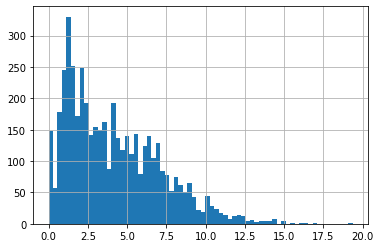

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
164,3.25,m,NaN,m,3.25 meter
521,3.5,m,NaN,m,3.5 meter
917,2.5,m,NaN,m,2.5 meter
1071,1.55,m,NaN,m,1.55 meter
1114,1.75,m,NaN,m,1.75 meter
...,...,...,...,...,...
328277,17,m,NaN,m,17.0 meter
328278,5.8,m,NaN,m,5.8 meter
328279,0.3,m,NaN,m,0.3 meter
328280,15.5,m,NaN,m,15.5 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
19826,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28210,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
32518,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
36071,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
36283,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...
254253,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
254360,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
254890,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
255089,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
19826,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28210,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
28246,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
28618,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
29360,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...
254253,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
254360,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
254890,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
255089,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


All these were missing both a value and unit so nothing could be done

In [29]:
# Aggregate Secchi data by station to look at results spatially
cols = ['MonitoringLocationIdentifier','Secchi']
secchi_df = df.loc[df['Secchi'].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in secchi_df['Secchi']]
secchi_df['secchi_magnitude'] = pandas.Series(avg, index=secchi_df['Secchi'].index) 
secchi_df_agg = secchi_df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
cols = ['MonitoringLocationIdentifier', 'secchi_magnitude']
secchi_df_agg['mean'] = secchi_df[cols].groupby('MonitoringLocationIdentifier').mean()
secchi_df_agg.reset_index(inplace=True)
secchi_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
671,NARS_WQX-NLA_MA-10032,1,3.150000
672,NARS_WQX-NLA_RI-10051,1,1.965000
673,NARS_WQX-NLA_RI-10062,1,2.540000
674,USGS-01113895,1,19.380200


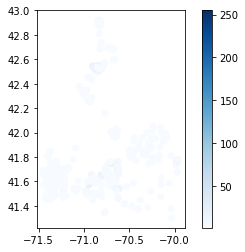

In [30]:
# Map Secchi by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
secchi_df_agg = wrangle.merge_tables(secchi_df_agg, stations_clipped, gdf_cols, merge_cols)
secchi_gdf = geopandas.GeoDataFrame(secchi_df_agg, geometry='geometry')

# Map Counts
secchi_gdf.plot(column='cnt', cmap='Blues', legend=True)

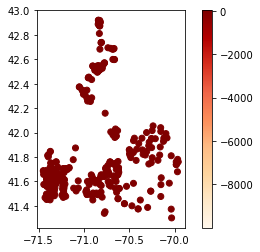

In [31]:
# Map Averages
secchi_gdf.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    103380.000000
mean         15.676460
std           7.479749
min          -6.000000
25%          10.500000
50%          15.800000
75%          21.500000
max         910.000000
dtype: float64
Unusable results: 210
Usable results with inferred units: 217
Results outside threshold (0.0 to 60.55495722599763): 113


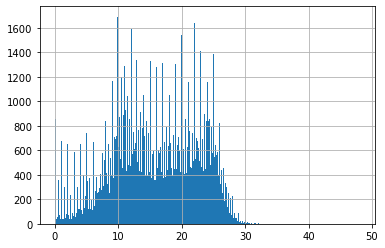

In [32]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [33]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
0,27.54,deg C,NaN,27.54 degree_Celsius,degC
6,11,deg C,NaN,11.0 degree_Celsius,degC
7,23.4,deg C,NaN,23.4 degree_Celsius,degC
12,18.47,deg C,NaN,18.47 degree_Celsius,degC
16,22.5,deg C,NaN,22.5 degree_Celsius,degC
...,...,...,...,...,...
329470,12.6,deg C,NaN,12.6 degree_Celsius,degC
329472,12.1,deg C,NaN,12.1 degree_Celsius,degC
329474,8.3,deg C,NaN,8.3 degree_Celsius,degC
329478,21.8,deg C,NaN,21.8 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
92189,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
92190,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
92191,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
92192,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
92193,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...
93531,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
93532,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
93534,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
126417,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
570,8,count,NaN,NaN,count
1227,8,count,NaN,NaN,count
2496,## (Censored),deg C,"ResultMeasureValue: ""## (Censored)"" result can...",NaN,degC
3328,26.6.,deg C,"ResultMeasureValue: ""26.6."" result cannot be used",NaN,degC
4822,8,count,NaN,NaN,count
...,...,...,...,...,...
194518,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
209956,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
211855,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
212596,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [37]:
# Aggregate temperature data by station
cols = ['MonitoringLocationIdentifier','Temperature']
temp_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in temp_df[cols[1]]]
temp_df['Temperature_magnitude'] = pandas.Series(avg, index=temp_df[cols[1]].index) 
temp_df_agg = temp_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['Temperature_magnitude']
temp_df_agg['mean'] = temp_df[cols].groupby(cols[0]).mean()
temp_df_agg.reset_index(inplace=True)
temp_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
4509,USGS-425447071234501,1,9.400000
4510,USGS-425450070513101,1,8.800000
4511,USGS-425456071260901,1,8.000000
4512,USGS-425517071041001,2,15.750000


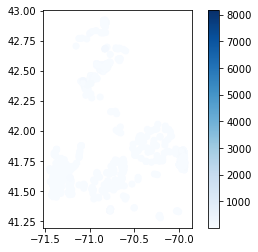

In [38]:
# Map Temperature by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
temperature_df_agg = wrangle.merge_tables(temp_df_agg, stations_clipped, gdf_cols, merge_cols)
temp_gdf = geopandas.GeoDataFrame(temperature_df_agg, geometry='geometry')
# Map Counts
temp_gdf.plot(column='cnt', cmap='Blues', legend=True)

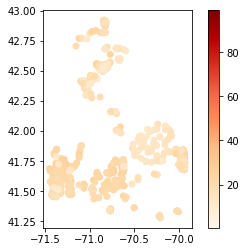

In [39]:
# Map Averages
temp_gdf.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
4,79.5621177754163,%,NaN,6.573686649405561 milligram / liter
9,4.2,mg/l,NaN,4.2 milligram / liter
11,7.58,mg/l,NaN,7.58 milligram / liter
13,7.25,mg/l,NaN,7.25 milligram / liter
15,13.4,mg/l,NaN,13.4 milligram / liter
...,...,...,...,...
324231,10.4,mg/l,NaN,10.4 milligram / liter
324239,9.1,mg/l,NaN,9.1 milligram / liter
324241,10.7,mg/l,NaN,10.7 milligram / liter
324243,9.7,mg/l,NaN,9.7 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
4,79.5621177754163,%,NaN,6.573686649405561 milligram / liter
25,79.9127372188287,%,NaN,6.602655993342436 milligram / liter
127,90.4507616092312,%,NaN,7.473342598767409 milligram / liter
163,75.22647711386,%,NaN,6.215461605497805 milligram / liter
181,76.1300019021517,%,NaN,6.290113826985498 milligram / liter
...,...,...,...,...
257493,5.45,ml/l,NaN,0.0450297116781 milligram / liter
257540,6.48,ml/l,NaN,0.053539914068640004 milligram / liter
257581,5.21,ml/l,NaN,0.04304675189778 milligram / liter
257586,4.10,ml/l,NaN,0.03387556291379999 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate DO data by station
cols = ['MonitoringLocationIdentifier','DO']
do_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in do_df[cols[1]]]
do_df['DO_magnitude'] = pandas.Series(avg, index=do_df[cols[1]].index) 
do_df_agg = do_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['DO_magnitude']
do_df_agg['mean'] = do_df[cols].groupby(cols[0]).mean()
do_df_agg.reset_index(inplace=True)
do_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
1975,OARS-SUD-096,48,5.300833
1976,OARS-SUD-098,14,6.037143
1977,OARS-SUD-144,86,9.317209
1978,OARS-SUD-236,3,7.813333


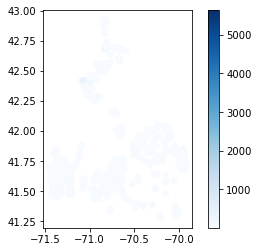

In [44]:
# Map DO by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
do_df_agg = wrangle.merge_tables(do_df_agg, stations_clipped, gdf_cols, merge_cols)
do_gdf = geopandas.GeoDataFrame(do_df_agg, geometry='geometry')
# Map Counts
do_gdf.plot(column='cnt', cmap='Blues', legend=True)

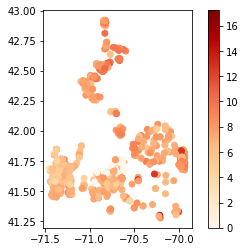

In [45]:
# Map Averages
do_gdf.plot(column='mean', cmap='OrRd', legend=True)

##### pH

-Usable results-
count    61769.000000
mean         6.369514
std          3.187518
min         -3.124705
25%          5.400000
50%          6.450000
75%          7.200000
max        715.000000
dtype: float64
Unusable results: 14
Usable results with inferred units: 215
Results outside threshold (0.0 to 25.494619581064644): 12


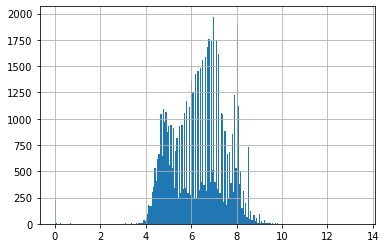

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
3,4.5,None,NaN,4.5 dimensionless
5,7.17,None,NaN,7.17 dimensionless
8,6.64,None,NaN,6.64 dimensionless
14,6.23,None,NaN,6.23 dimensionless
30,6.55,None,NaN,6.55 dimensionless
...,...,...,...,...
329471,5.7,std units,NaN,5.7 dimensionless
329473,5.1,std units,NaN,5.1 dimensionless
329475,7.4,std units,NaN,7.4 dimensionless
329479,7,std units,NaN,7.0 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\basis.py:95: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn('Mismatched {}'.format(flag))


-Usable results-
count    16283.000000
mean        25.494700
std         33.792785
min          0.000000
25%         26.585000
50%         30.730000
75%         31.750000
max       4003.482834
dtype: float64
Unusable results: 220
Usable results with inferred units: 1
Results outside threshold (0.0 to 228.25140801126528): 2


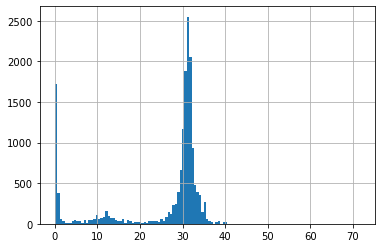

In [48]:
# Salinity
# Note: this has some weird units ('deg C') that may cause issue unless ignored
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
18,31.68,ppt,NaN,31.68 Practical_Salinity_Units
27,0.32,ppth,NaN,0.32 Practical_Salinity_Units
32,33.2,ppth,NaN,33.2 Practical_Salinity_Units
38,32.9,ppth,NaN,32.9 Practical_Salinity_Units
44,29.99,ppt,NaN,29.99 Practical_Salinity_Units
...,...,...,...,...
324208,7.5,ppth,NaN,7.5 Practical_Salinity_Units
324210,30,ppth,NaN,30.0 Practical_Salinity_Units
324225,29,ppth,NaN,29.0 Practical_Salinity_Units
324233,5,ppth,NaN,5.0 Practical_Salinity_Units


##### Nitrogen

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'ppm' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'percent' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT
  warn("WARNING: " + problem)


Nitrogen


C:\ArcGIS\Local_GIS\Python\envs\arc-py3-osgeo\lib\site-packages\numpy\core\_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


-Usable results-
count    2132.000000
mean        1.498011
std         4.295066
min         0.000800
25%         0.093000
50%         0.270000
75%         1.030000
max        30.080000
dtype: float64
Unusable results: 135
Usable results with inferred units: 0
Results outside threshold (0.0 to 27.26840855779434): 2


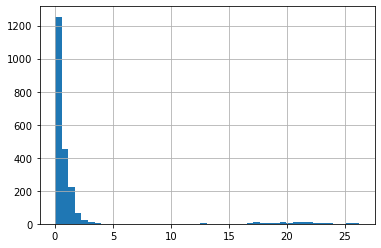

In [50]:
# Note Nitrogen value as '%' is in there for Cape, but weird
# Nitrogen had a problem with one of the units that is unexepected
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
227,0.772824,mg/l,NaN,0.772824 milligram / liter
1148,1.571196,mg/l,NaN,1.5711959999999998 milligram / liter
1199,1.591044,mg/l,NaN,1.5910440000000001 milligram / liter
1304,0.91248,mg/l,NaN,0.91248 milligram / liter
1348,0.751752,mg/l,NaN,0.7517520000000001 milligram / liter
...,...,...,...,...
329236,0.064,mg/l,NaN,0.064 milligram / liter
329251,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
329270,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
329278,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


##### Conductivity

-Usable results-
count     1649.000000
mean      1169.953952
std       3726.835349
min          0.000000
25%        325.000000
50%        450.000000
75%        593.000000
max      39960.000000
dtype: float64
Unusable results: 1146
Usable results with inferred units: 0
Results outside threshold (0.0 to 23530.966045075165): 19


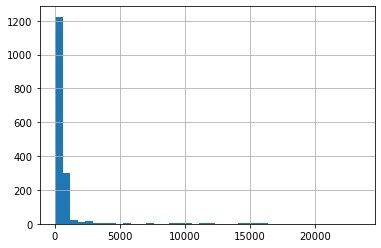

In [52]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True, errors='ignore')

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
118,447,uS/cm,NaN,447.0 microsiemens / centimeter
130,590,uS/cm,NaN,590.0 microsiemens / centimeter
141,274,uS/cm,NaN,274.0 microsiemens / centimeter
166,456,uS/cm,NaN,456.0 microsiemens / centimeter
188,325,uS/cm,NaN,325.0 microsiemens / centimeter
...,...,...,...,...
197806,621,uS/cm,NaN,621.0 microsiemens / centimeter
197939,409,uS/cm,NaN,409.0 microsiemens / centimeter
197993,Below Reporting Limit,uS/cm,"ResultMeasureValue: ""Below Reporting Limit"" re...",NaN
198125,566,uS/cm,NaN,566.0 microsiemens / centimeter


##### Chlorophyll a

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'ppb' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT
  warn("WARNING: " + problem)


-Usable results-
count    3861.000000
mean        0.621392
std         3.404011
min        -0.002400
25%         0.001680
50%         0.005010
75%         0.019400
max        92.900000
dtype: float64
Unusable results: 130
Usable results with inferred units: 9
Results outside threshold (0.0 to 21.045456572202912): 29


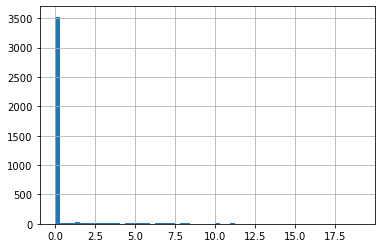

In [54]:
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
64,5.91,ug/l,NaN,0.00591 milligram / liter
136,9.48,ug/l,NaN,0.00948 milligram / liter
192,19.0,mg/m3,NaN,0.019000000000000003 milligram / liter
234,1.296,ug/cm2,ResultMeasure/MeasureUnitCode: 'ug/cm2' UNDEFI...,1.296 milligram / liter
280,21.0,mg/m3,NaN,0.021000000000000005 milligram / liter
...,...,...,...,...
329308,1.5,ug/l,NaN,0.0015 milligram / liter
329357,2.8,ug/l,NaN,0.0028 milligram / liter
329413,2.3,ug/l,NaN,0.0023 milligram / liter
329422,2.2,ug/l,NaN,0.0022 milligram / liter


##### Organic Carbon

-Usable results-
count      5719.000000
mean       5722.981685
std       36877.463061
min      -90000.000000
25%           1.500000
50%           4.910000
75%           9.400000
max      530000.000000
dtype: float64
Unusable results: 65
Usable results with inferred units: 0
Results outside threshold (0.0 to 226987.76005346686): 40


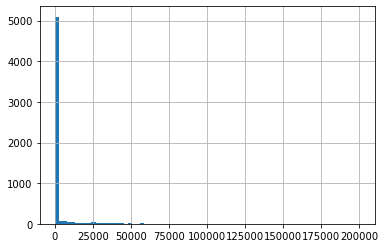

In [56]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
40,3.7,mg/l,NaN,3.7 milligram / liter
88,5.62,mg/l,NaN,5.62 milligram / liter
510,## (Censored),mg/l,"ResultMeasureValue: ""## (Censored)"" result can...",NaN
832,2.7,mg/l,NaN,2.7 milligram / liter
932,3.57,mg/l,NaN,3.57 milligram / liter
...,...,...,...,...
329235,3.97,mg/l,NaN,3.97 milligram / liter
329250,3.22,mg/l,NaN,3.22 milligram / liter
329269,6.73,mg/l,NaN,6.73 milligram / liter
329277,5.77,mg/l,NaN,5.77 milligram / liter


##### Turbidity (NTU)

In [58]:
# Bad units include 'm' and 'count'
#df_turb = df[df['CharacteristicName']=='Turbidity']

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:1081: UserWarning: Bad Turbidity unit: count
  warn('Bad Turbidity unit: {}'.format(unit))


-Usable results-
count    14433.000000
mean        31.874216
std        108.565750
min         -2.000000
25%          1.300000
50%          2.700000
75%          8.700000
max       4100.000000
dtype: float64
Unusable results: 443
Usable results with inferred units: 275
Results outside threshold (0.0 to 683.268717959804): 99


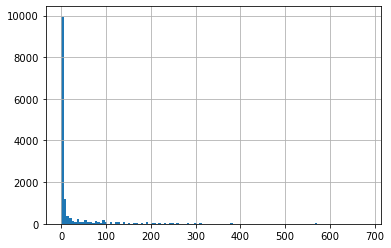

In [59]:
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
34,1.7,NTU,NaN,1.7 Nephelometric_Turbidity_Units
42,8.1,NTU,NaN,8.1 Nephelometric_Turbidity_Units
46,.7,NTU,NaN,0.7 Nephelometric_Turbidity_Units
73,6.11,NTU,NaN,6.11 Nephelometric_Turbidity_Units
74,NaN,NTU,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
329460,34,NTRU,NaN,34.0 Nephelometric_Turbidity_Units
329464,2.8,NTRU,NaN,2.8 Nephelometric_Turbidity_Units
329467,2.8,NTRU,NaN,2.8 Nephelometric_Turbidity_Units
329477,1.9,NTRU,NaN,1.9 Nephelometric_Turbidity_Units


##### Sediment

In [61]:
df = harmonize.harmonize_generic(df, 'Sediment', report=False, errors='ignore')

In [62]:
df.loc[df['CharacteristicName']=='Sediment', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
284135,39,%,NaN,390.0 gram / kilogram
284526,33,%,NaN,330.0 gram / kilogram
294020,0.012,g,NaN,NaN
294021,0.0037,g,NaN,NaN
294022,0.0048,g,NaN,NaN
...,...,...,...,...
328673,12.5701,g,NaN,NaN
328674,4.7241,g,NaN,NaN
328773,0.0207,g,NaN,NaN
328785,0.0174,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
df = harmonize.harmonize_generic(df, 'Phosphorus')

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'ppm' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'percent' UNDEFINED UNIT
  warn("WARNING: " + problem)


P
Phosphorus


C:\ArcGIS\Local_GIS\Python\envs\arc-py3-osgeo\lib\site-packages\numpy\core\_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "__Phosphorus" column for  , may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Non-filterable_Phosphorus" column for Non-filterable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Comb_Available_Phosphorus" column for Comb Available, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Suspended_Phosphorus" column for Suspended, may be error
  w

Note: the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# len(df[df['CharacteristicName']=='Phosphorus'])
list(set(df['CharacteristicName']))

['Nitrogen',
 'Conductivity',
 'Turbidity',
 'Escherichia coli',
 'Sediment',
 'Fecal Coliform',
 'Phosphorus',
 'Dissolved oxygen (DO)',
 'Organic carbon',
 'Depth, Secchi disk depth',
 'Salinity',
 'pH',
 'Chlorophyll a',
 'Temperature, water']

In [65]:
# Total dissolved phosphorus
#df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

In [66]:
# Total phosphorus
#df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

-Usable results-
count    6.442000e+03
mean     5.282978e+03
std      1.456090e+05
min      0.000000e+00
25%      1.725000e+01
50%      7.700000e+01
75%      3.400000e+02
max      9.300000e+06
dtype: float64
Unusable results: 1265
Usable results with inferred units: 1
Results outside threshold (0.0 to 878936.8168145093): 6


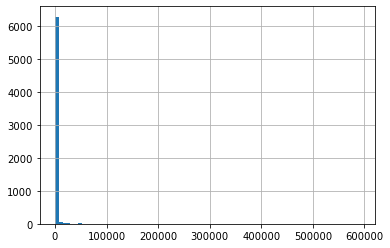

In [67]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
8649,710,cfu/100ml,NaN,710.0 Colony_Forming_Units / milliliter
8768,33,cfu/100ml,NaN,33.0 Colony_Forming_Units / milliliter
8826,2,cfu/100ml,NaN,2.0 Colony_Forming_Units / milliliter
8864,830,cfu/100ml,NaN,830.0 Colony_Forming_Units / milliliter
8982,8,cfu/100ml,NaN,8.0 Colony_Forming_Units / milliliter
...,...,...,...,...
323519,24000,cfu/100ml,NaN,24000.0 Colony_Forming_Units / milliliter
323533,36,cfu/100ml,NaN,36.0 Colony_Forming_Units / milliliter
323549,4300,cfu/100ml,NaN,4300.0 Colony_Forming_Units / milliliter
323558,2400,cfu/100ml,NaN,2400.0 Colony_Forming_Units / milliliter


###### Excherichia Coli

-Usable results-
count     16669.000000
mean        547.340547
std        3505.964764
min           0.000000
25%          22.600000
50%          82.000000
75%         240.000000
max      173290.000000
dtype: float64
Unusable results: 2333
Usable results with inferred units: 0
Results outside threshold (0.0 to 21583.129132383958): 55


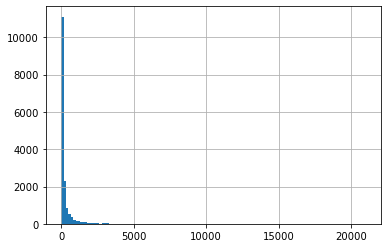

In [69]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
1,10,MPN/100ml,NaN,10.0 Colony_Forming_Units / milliliter
2,248,MPN/100ml,NaN,248.0 Colony_Forming_Units / milliliter
10,920.8,MPN,NaN,920.8 Colony_Forming_Units / milliliter
17,275,MPN/100ml,NaN,275.0 Colony_Forming_Units / milliliter
21,285,MPN/100ml,NaN,285.0 Colony_Forming_Units / milliliter
...,...,...,...,...
329438,2,MPN/100 ml,NaN,2.0 Colony_Forming_Units / milliliter
329447,46,MPN/100 ml,NaN,46.0 Colony_Forming_Units / milliliter
329463,17,MPN/100 ml,NaN,17.0 Colony_Forming_Units / milliliter
329476,12,MPN/100 ml,NaN,12.0 Colony_Forming_Units / milliliter


### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

In [71]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 16283 
Mean: 25.494700386857115 PSU


In [72]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
# Coerce quantity values to str (wrapper doesn't recognize quantity as it should)
cond_series = cond_series.astype(str)
# Convert values to PSU
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)

In [73]:
df.loc[df['Salinity'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
18,31.68,ppt,NaN,31.68 Practical_Salinity_Units
27,0.32,ppth,NaN,0.32 Practical_Salinity_Units
32,33.2,ppth,NaN,33.2 Practical_Salinity_Units
38,32.9,ppth,NaN,32.9 Practical_Salinity_Units
44,29.99,ppt,NaN,29.99 Practical_Salinity_Units
...,...,...,...,...
324208,7.5,ppth,NaN,7.5 Practical_Salinity_Units
324210,30,ppth,NaN,30.0 Practical_Salinity_Units
324225,29,ppth,NaN,29.0 Practical_Salinity_Units
324233,5,ppth,NaN,5.0 Practical_Salinity_Units


In [74]:
# Now note updated values
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 17932 
Mean: 23.209704405487074 PSU


In [75]:
# Better to do after transposing so it doesn't generate duplicates?
# Start with two field 'Salinity' and 'Conductivity' that have already been harmonized
# Move the data from the Conductivity field to the salinity field

#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(harmonize_WQP.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [76]:
# Threshholds and reports
#e.g. PSU 0-42

### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [77]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-07-16,12:40:00,EDT
1,2013-10-08,06:08:00,EST
2,2013-08-19,NaN,NaN
3,2013-06-26,11:06:00,EDT
4,2013-08-21,05:35:00,EST
...,...,...,...
329480,2022-05-05,12:15:00,EDT
329481,2022-05-05,12:15:00,EDT
329482,2022-05-05,12:15:00,EDT
329483,2022-05-05,12:15:00,EDT


In [78]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-07-16,2013-07-16 16:40:00+00:00
1,2013-10-08,2013-10-08 11:08:00+00:00
2,2013-08-19,NaT
3,2013-06-26,2013-06-26 15:06:00+00:00
4,2013-08-21,2013-08-21 10:35:00+00:00
...,...,...
329480,2022-05-05,2022-05-05 16:15:00+00:00
329481,2022-05-05,2022-05-05 16:15:00+00:00
329482,2022-05-05,2022-05-05 16:15:00+00:00
329483,2022-05-05,2022-05-05 16:15:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

### Depth

In [79]:
# Indexing with depth

### Characteristic to Column (long to wide format)

In [80]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_DO,QA_Carbon,QA_Secchi,QA_Salinity,QA_pH,QA_Chlorophyll,QA_Temperature
0,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_LS_PB_7/16/2013_MFW_0.441,11NPSWRD_WQX-CACO_LS_PB,STORET-920933446,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131008269TEC01,CRWA-269T,STORET-872380044,NaN,NaN,None,Escherichia coli,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11113300,New Hampshire Department Of Environmental Serv...,11113300-DWWTF08192013-3,11113300-BCHDTBDERLF,STORET-271839243,NaN,NaN,NaN,Escherichia coli,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-15-0391,MASSDEP-W2412,STORET-762962184,NaN,NaN,NaN,pH,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MYRWA,Mystic River Watershed Association (Massachuse...,MYRWA-MAR036:201308210635:L:S,MYRWA-MAR036,STORET-495269544,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329480,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123251862,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329481,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123251872,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329482,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123251879,NaN,NaN,NaN,Escherichia coli,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329483,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123251881,NaN,NaN,NaN,Turbidity,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

17 new columns


In [82]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

11999 fewer rows


In [83]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [84]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [85]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier',
       'ResultIdentifier', 'ProviderName', 'Secchi', 'Temperature', 'DO', 'pH',
       'Salinity', 'Nitrogen', 'Speciation', 'Conductivity', 'Chlorophyll',
       'Carbon', 'Turbidity', 'Sediment', 'Phosphorus', 'TP_Phosphorus',
       'TDP_Phosphorus', 'Other_Phosphorus', 'Unfiltered_Phosphorus',
       'Bed_Sediment_Phosphorus', 'Fecal_Coliform', 'E_coli', 'StartDate',
       'Activity_datetime', 'QA_Nitrogen', 'QA_Conductivity', 'QA_Turbidity',
       'QA_E_coli', 'QA_Sediment', 'QA_Fecal_Coliform', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Unfiltered_Phosphorus',
       'QA_Bed_Sediment_Phosphorus', 'QA_DO', 'QA_Carbon', 'QA_Secchi',
       'QA_Salinity', 'QA_pH', 'QA_Chlorophyll', 'QA_Temperature', 'Depth'],
      dtype='object')

In [86]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,ProviderName,Secchi,Temperature,DO,pH,...,QA_Unfiltered_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_DO,QA_Carbon,QA_Secchi,QA_Salinity,QA_pH,QA_Chlorophyll,QA_Temperature,Depth
0,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_LS_PB_7/16/2013_MFW_0.441,11NPSWRD_WQX-CACO_LS_PB,STORET-920933446,STORET,NaN,27.54 degree_Celsius,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131008269TEC01,CRWA-269T,STORET-872380044,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11113300,New Hampshire Department Of Environmental Serv...,11113300-DWWTF08192013-3,11113300-BCHDTBDERLF,STORET-271839243,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-15-0391,MASSDEP-W2412,STORET-762962184,STORET,NaN,NaN,NaN,4.5 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MYRWA,Mystic River Watershed Association (Massachuse...,MYRWA-MAR036:201308210635:L:S,MYRWA-MAR036,STORET-495269544,STORET,NaN,NaN,6.573686649405561 milligram / liter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_Conductivity',
 'QA_E_coli',
 'QA_Sediment',
 'QA_Unfiltered_Phosphorus',
 'QA_DO',
 'QA_Carbon']

In [88]:
# Join to stations to quickly aggegate/map
merge_cols = ['MonitoringLocationIdentifier', 'OrganizationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(main_df, stations_clipped, gdf_cols, merge_cols)

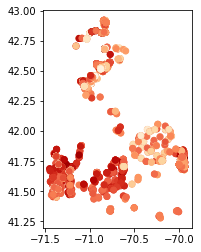

In [89]:
# Map average temperature
results_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')
results_gdf.plot(column='Temperature', cmap='OrRd')